In [1]:
import re
import json
import os
import glob
import shutil
from pprint import pprint

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
)


# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="whitegrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

In [2]:
# Import my modules
from ndg_tools import language as lang, cleaning, plotting, utils
from ndg_tools.sklearn import selection

RUN_LANGDETECT = False

# Run time-consuming grid searches
RUN_SWEEPS = frozenset()

FIT_MODELS = frozenset()

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ndgig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Business Problem

Amazon has asked me to build a product classifier for two purposes: (1) integrating new products into their classification scheme, and (2) flagging products which are probably misclassified. They requested that I make some recommendations related to product classification and its uses.

Accuracy is my highest priority, but I have a taste for interpretability and transparency, so the classifier I develop is sure to yield some insights about the data.

# Sourcing the Data

The Amazon product data I've chosen doesn't come directly from Amazon, but rather from three AI researchers, Jianmo Ni, Jiacheng Li, and Julian McAuley, who gathered it for their paper "Justifying Recommendations using Distantly-Labeled Reviews and Fine-grained Aspects." The review data extends from May 1996 to October 2018, which is about when they released the update. Their focus was primarily on reviews, but the dataset also has metadata for ~15-million products. The researchers don't say how they acquired the data, but judging from the HTML tags and chunks of JavaScript, they probably scraped it.

Since the full dataset is ~15M samples and ~13GB, I've created a separate notebook called `big_clean.ipynb` in which I download, reformat, and scrub the data until I'm left with ~4M samples. Despite the long and tortuous journey that is `big_clean.ipynb`, there's still much more to go.

# Preparing the Data

I begin by loading the data and doing a preliminary cleaning check.

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=["text", "title", "brand", "main_cat",],
)

df

,text,title,brand,main_cat
asin,,,,
1441072241,come tell me how you lived: native american hi...,come tell me how you lived: native american hi...,enter the arena,all beauty
6090113980,prayer rug carpet mat gebetsteppich islamic mu...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,all beauty
7250468162,no7 stay perfect foundation cool vanilla by no...,no7 stay perfect foundation cool vanilla by no7,no7,all beauty
8279996397,imagen bendita por su santidad our lady of cha...,imagen bendita por su santidad our lady of cha...,chango,all beauty
9197882747,hall of femmes: lella vignelli (hall of femmes...,hall of femmes: lella vignelli (hall of femmes),oyster press,all beauty
...,...,...,...,...
B01HHFHGES,xiaokong women's high low hem sleeveless flora...,xiaokong women's high low hem sleeveless flora...,xiaokong,books
B01HHX5AF2,duxa women's working my adipose off symbol gra...,duxa women's working my adipose off symbol gra...,duxa,books
B01HHZYKYW,aliixun2 unisex the 2016 rio de janeiro olympi...,aliixun2 unisex the 2016 rio de janeiro olympi...,aliixun2,books


<IPython.core.display.Javascript object>

In [4]:
df.duplicated().any()

False

<IPython.core.display.Javascript object>

In [5]:
df.isna().any()

text        False
title       False
brand       False
main_cat    False
dtype: bool

<IPython.core.display.Javascript object>

No duplicates or nulls (at least ostensibly). Looks good.

Next I plot the main categories to get a sense of the balance.

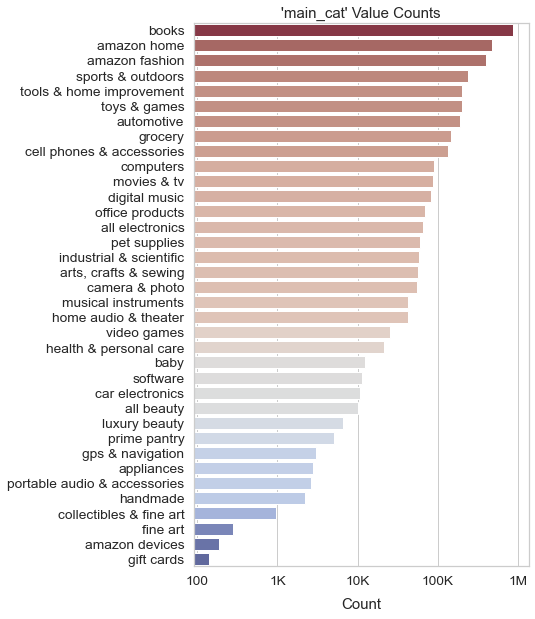

<IPython.core.display.Javascript object>

In [6]:
ax = plotting.countplot(df.loc[:, "main_cat"], size=(6, 10), log_scale=True)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

The classes are very imbalanced, which is why I had to plot them on a logarithmic scale. Books are at the top.

## Refining the Brands

I begin with the brand terms, which will be very important for the classifier.

In [7]:
empty_brand = df.loc[df.brand.str.fullmatch("\s*")]
empty_brand

,text,title,brand,main_cat
asin,,,,
B000050B67,norelco 5655x deluxe advantage wet/dry cordles...,norelco 5655x deluxe advantage wet/dry cordles...,,all beauty
B000050B69,norelco t7500 deluxe cord/cordless rechargeabl...,norelco t7500 deluxe cord/cordless rechargeabl...,,all beauty
B000050FDP,braun 6520 flex integral ultra speed rechargea...,braun 6520 flex integral ultra speed rechargea...,,all beauty
B000052YD8,scope original mint mouthwash 50.7 fl oz. scop...,scope original mint mouthwash 50.7 fl oz,,all beauty
B00005336W,dove nutrium nutrient beads nourishing body wa...,dove nutrium nutrient beads nourishing body wa...,,all beauty
...,...,...,...,...
B01H0UDFXQ,marc lawrence's 2016 playbook football preview...,marc lawrence's 2016 playbook football preview,,books
B01H3U5GNA,american original soft and cozy coastal stripe...,american original soft and cozy coastal stripe...,,books
B01H87P6YM,hitachi 43in 2160p 120hz 4k uhd led tv. the ne...,hitachi 43in 2160p 120hz 4k uhd led tv,,books


<IPython.core.display.Javascript object>

Looks like there are over about 1.6 million empty brand entries. I'll replace those with 'none' for now.

In [8]:
df.loc[empty_brand.index, "brand"] = "none"
df.loc[df.brand.str.fullmatch("\s*")]

,text,title,brand,main_cat
asin,,,,


<IPython.core.display.Javascript object>

In [9]:
del empty_brand

<IPython.core.display.Javascript object>

Next, I'm going to tokenize the brands using the default Scikit-Learn tokenizer regex (r'\b\w\w+\b'). This is the default value for 'token_pattern' in `CountVectorizer`, `HashingVectorizer`, and `TfidfVectorizer`.

I like the default Scikit-Learn tokenizer because it ignores punctuation and grabs sequences of 2 or more word characters (within word boundaries). It strips out most of the noise in a single stroke.

I define a function below using this pattern.

In [10]:
def sklearn_tokenize(docs, n_jobs=None):
    pattern = re.compile(r"\b\w\w+\b")
    return lang.process_strings(
        docs, pattern.findall, n_jobs=n_jobs, bar_desc="sklearn_tokenize"
    )

<IPython.core.display.Javascript object>

It's a short function, but a powerful one. It's **polymorphic**, meaning that it it behaves differently depending on the input type. If `docs` is a string, it simply returns the list of tokens. However, if `docs` is a container type like `Series` or `DataFrame`, it applies the tokenizer to every element. It also features **multiprocessing**, which can dramatically increase performance on large datasets.

Like many functions you'll see this notebook, it uses the infrastructure provided by my low-level function `lang.process_strings`.

In [11]:
help(lang.process_strings)

Help on function process_strings in module tools.language.utils:

process_strings(strings: Union[str, Iterable[str]], func: Callable[[str], Any], n_jobs: int = None, show_bar: bool = True, bar_desc: str = None, **kwargs) -> Any
    Apply `func` to a string or iterable of strings (elementwise).
    
    Most string filtering/processing functions in the language module
    are polymorphic, capable of handling either a single string or an
    iterable of strings. Whenever possible, they rely on this generic
    function to apply a callable to string(s). This allows them to
    behave polymorphically and take advantage of multiprocessing while
    having a simple implementation.
    
    This is a single dispatch generic function, meaning that it consists
    of multiple specialized sub-functions which each handle a different
    argument type. When called, the dispatcher checks the type of the first
    positional argument and then dispatches the sub-function registered
    for that type.

<IPython.core.display.Javascript object>

In the following cell, I transliterate the brand names to ASCII, tokenize them, and then immediately detokenize them. I want to reduce the number of unique values by reducing the number of near-duplicates.

In [12]:
df["brand"] = lang.force_ascii(df.loc[:, "brand"], n_jobs=-1)
df["brand"] = sklearn_tokenize(df.loc[:, "brand"], n_jobs=-1)
df["brand"] = df.loc[:, "brand"].str.join("_")
df["brand"].value_counts()

force_ascii:   0%|          | 0/3692413 [00:00<?, ?it/s]

sklearn_tokenize:   0%|          | 0/3692413 [00:00<?, ?it/s]

none                         149124
generic                       10178
yu_gi_oh                       7075
magic_the_gathering            6488
nike                           5774
                              ...  
behrouz_farhang_boroujeny         1
joshua_howarth                    1
edward_stupp                      1
alexander_schrijver               1
aliixun2                          1
Name: brand, Length: 768552, dtype: int64

<IPython.core.display.Javascript object>

Over 760,000 unique brands! I'm going to use the brands as ngram phrases in the text, but I suspect most of these are too obscure to be useful. One-off brand terms are almost completely useless for a term-frequency-based classification, since they'll only appear in one vector.

In [13]:
def plot_brand_size_dist(data, brand_col="brand", bins=50, log_scale=True, tick_prec=0):
    brand_counts = data[brand_col].value_counts()
    g = sns.displot(
        data=brand_counts.to_frame(),
        x=brand_col,
        log_scale=log_scale,
        bins=bins,
        aspect=2,
    )
    g.axes[0, 0].set(
        xlabel="Product Count",
        ylabel="Number of Brands",
        title="Distribution of Brand Sizes (Product Count)",
    )
    g.axes[0, 0].yaxis.set_major_formatter(plotting.big_number_formatter(tick_prec))
    g.axes[0, 0].xaxis.set_major_formatter(plotting.big_number_formatter(tick_prec))

<IPython.core.display.Javascript object>

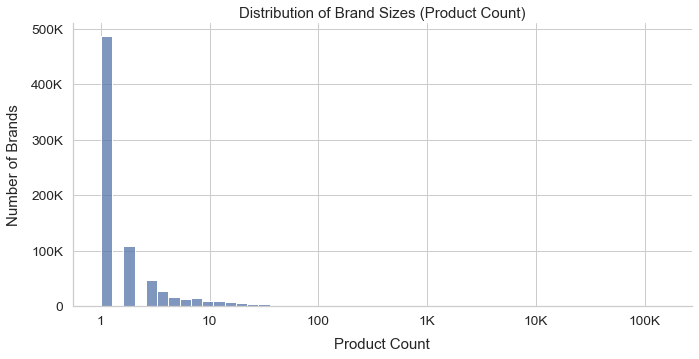

<IPython.core.display.Javascript object>

In [14]:
plot_brand_size_dist(df)

Over 500,000 brands have just one instance. I'm not interested in those.

In order to engineer a solid dataset for product classification, I'm going to keep only the biggest brands in each main category. That ought to get rid of most of the brand noise and make room for some signal.

For each main category, (with some exceptions) I keep only the top 1% of brands. Again, I'm measuring brand size in terms of number of products. Main categories with less than 1,000 samples are exempt from the pruning. Furthermore, all *none* entries will be dropped except in categories which are almost entirely *none* (in order to preserve the categories). The 'fine art' category, for instance, is ~99% *none*, presumably due to the unique nature of the products. Currently Amazon does show brands for fine art products, but that may have been different in 2018, when this data was collected.

In [15]:
# Drop brands below this quantile
qcut = 0.99

# Keep nulls if they dominate the category
null_dom_thresh = 0.95

# Don't prune small categories
protected_thresh = 1000

pruned_df = []

for cat, group in df.groupby("main_cat"):

    # Ignore small categories
    if len(group) <= protected_thresh:
        pruned_df.append(group)
        continue

    # Drop nulls if freq under `null_dom_thresh`
    brand_counts = group["brand"].value_counts(1)
    if brand_counts.get("none", 1.0) < null_dom_thresh:
        group = group.loc[group.brand != "none"]

    print(cat)
    print("-" * len(cat))

    # Drop brands below quantile `qcut`
    group = utils.prune_categories(group, "brand", qcut=qcut)

    print("\n")
    pruned_df.append(group)

pruned_df = pd.concat(pruned_df)

all beauty
----------
                             Status  Support
crystalage                 retained       89
makingcosmetics            retained       80
kroo                       retained       67
crest                      retained       64
vktech                     retained       60
...                             ...      ...
hay_where_that_blue_stuff   dropped        1
antopos                     dropped        1
dudley                      dropped        1
vedco                       dropped        1
bial_ex                     dropped        1

[5177 rows x 2 columns]



all electronics
---------------
                             Status  Support
sony                       retained     1202
panasonic                  retained     1137
samsung                    retained      910
hp                         retained      635
startech                   retained      523
...                             ...      ...
apac_opto_electronics_inc   dropped        1
weishan           



handmade
--------
                         Status  Support
none                   retained     2212
unique                  dropped        6
marvel                  dropped        3
apple                   dropped        2
monster                 dropped        2
brenda_elaine_jewelry   dropped        1
lego                    dropped        1



health & personal care
----------------------
                         Status  Support
maxiaids               retained      139
liliane_memorials      retained      126
crystalage             retained      115
terravita              retained       89
big_dot_of_happiness   retained       88
...                         ...      ...
mohdoh                  dropped        1
earth_elements          dropped        1
tamarack_technologies   dropped        1
hot_booties             dropped        1
sierra_bees             dropped        1

[10324 rows x 2 columns]



home audio & theater
--------------------
                 Status  Support
sony   

<IPython.core.display.Javascript object>

In [16]:
size_reduct = 1 - (len(pruned_df) / len(df))
print(f"Reduced n_samples by {size_reduct:.0%}")
pruned_df

Reduced n_samples by 71%


,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty
...,...,...,...,...
B01HH6JEOC,the sims 4 kids room stuff [online game code]....,the sims 4 kids room stuff [online game code],electronic_arts,video games
B01HIU43S4,1k games sega mega drive game console with wir...,1k games sega mega drive game console with wir...,sega,video games
B01HIZF83S,bioshock: the collection - playstation 4. retu...,bioshock: the collection - playstation 4,2k,video games


<IPython.core.display.Javascript object>

In [17]:
pruned_df.brand.nunique()

9117

<IPython.core.display.Javascript object>

This is an enormous dataset, so the top 1% of brands in each category leaves me with ~9k brands. That's a fairly large, yet manageable, number.

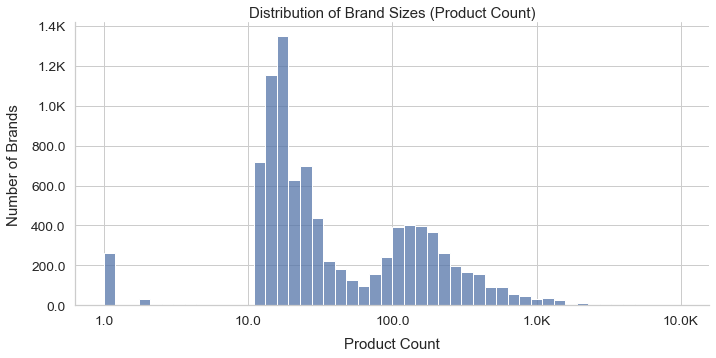

<IPython.core.display.Javascript object>

In [18]:
plot_brand_size_dist(pruned_df, tick_prec=1)

Although I only took the top 1% of brands in each category, most of the brands have 10-50 products. That seems like a healthy number.

The histogram also shows that there are ~400 single-product brands from the protected categories. That's fine. Those terms won't be very useful, but there's plenty of other useful information in those categories.

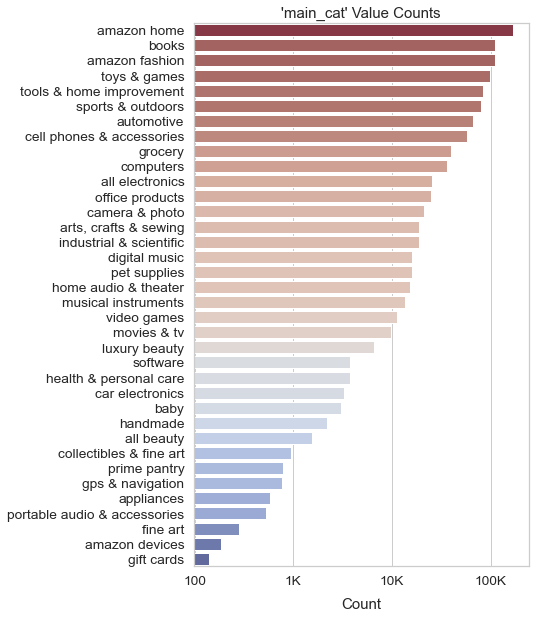

<IPython.core.display.Javascript object>

In [19]:
ax = plotting.plots.countplot(
    pruned_df.loc[:, "main_cat"], log_scale=True, size=(6, 10)
)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())

In [20]:
df = pruned_df
df.head()

,text,title,brand,main_cat
asin,,,,
B000050AUH,philips sonicare standard brush head. sonic wa...,philips sonicare standard brush head,philips_sonicare,all beauty
B000050B62,norelco 5841xl deluxe reflex action cord/cordl...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,all beauty
B000050B63,norelco 6826xl quadra action cord/cordless rec...,norelco 6826xl quadra action cord/cordless rec...,norelco,all beauty
B000050B64,norelco 6865xl quadra action cord/cordless rec...,norelco 6865xl quadra action cord/cordless rec...,norelco,all beauty
B000050B65,norelco 6885xl deluxe quadra action cord/cordl...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,all beauty


<IPython.core.display.Javascript object>

I check the brands of 'arts, crafts, & sewing' as a basic sanity check.

In [21]:
df.groupby("main_cat").get_group("arts, crafts & sewing").brand.value_counts()

lantern_press               1030
3drose                       829
beadaholique                 795
sizzix                       696
spellbinders                 597
                            ... 
m1n4b6                        86
unique_wood_shapes            85
crafter_companion             85
vogue_fabrics                 83
sparkles_make_it_special      82
Name: brand, Length: 96, dtype: int64

<IPython.core.display.Javascript object>

Seems to be a healthy number.

In [6]:
def data_checkpoint(data, path):
    """Save data to disk."""
    path = os.path.normpath(path)

    if os.path.isdir(path):
        shutil.rmtree(path)
        print("Overwriting...")

    data.to_parquet(
        path, engine="pyarrow", index=True, partition_cols=["main_cat"],
    )

    n_files = len(glob.glob(f"{path}/*/*.parquet"))
    print(f"{n_files} files created.")

In [23]:
data_checkpoint(df, "data/brand_checkpoint")

Overwriting...
36 files created.


<IPython.core.display.Javascript object>

## Engineering the Vocabulary

I engineer the model's vocabulary by preprocessing the text, developing a custom tokenizer, and constructing multi-word expressions. The purpose of the model is to assimilate novel products into Amazon's existing classification scheme. If the vocabulary is to serve that purpose, it will require some *a priori* decision-making.

To be clear, I don't intend to feed `TfidfVectorizer` a fixed vocabulary, because that would restrict my ability to tune the vocabulary later on. I plan on letting the vectorizer learn the vocabulary on its own, but I want it to learn the *right* vocabulary.

Before making any decisions, I define a function for creating a vocabulary from a sample of the corpus.

In [5]:
def build_sample_vocab(
    corpus, n_docs, *, tokenizer=None, sortby="length", random_state=363, n_jobs=-1,
):
    # Get sample of corpus
    if n_docs is None:
        samp_corpus = corpus
    else:
        samp_corpus = corpus.sample(n_docs, random_state=random_state)

    # Tokenize
    if tokenizer is None:
        # Check if already tokenized
        if not pd.api.types.is_list_like(corpus.iloc[0]):
            # Space tokenize if necessary
            samp_corpus = lang.space_tokenize(samp_corpus, n_jobs=n_jobs)
    else:
        samp_corpus = lang.process_strings(
            samp_corpus, tokenizer, n_jobs=n_jobs, show_bar=False,
        )

    # Build vocabulary
    vocab = samp_corpus.explode().value_counts()
    vocab = vocab.reset_index(name="freq").rename(columns={"index": "term"})

    # Add additional stats
    vocab["length"] = vocab.loc[:, "term"].str.len()
    vocab["uniq_ratio"] = vocab.loc[:, "term"].map(lang.uniq_ratio)

    return vocab.sort_values(sortby, ascending=False)

### Optimize the Tokenizer?

There are many tokenizers on the market. Shouldn't I grid-search over them all to maximize my accuracy score?

No. The choice of tokenizer requires some *human* intelligence. The purpose of the model is to classify new products into Amazon's existing categories. High test scores do not always indicate a better model&mdash;sometimes, they reflect overfitting.

Take for example `nltk.wordpunct_tokenize`. This tokenizer captures arbitrarily long sequences of punctuation in addition to normal words.

In [25]:
# Get small sample of corpus
wordpunct_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=nltk.wordpunct_tokenize
)

# Slice out some punctuation
wordpunct_vocab.loc[wordpunct_vocab.term.str.startswith("!"), "term"].head(10)

20526    !~~~~~~~~~~~~~~~~~
54493     !!!**************
61997         !!!!~~~~~~~~~
52762              !!~~~~~~
59332              !!!!!!!.
53266               !!!!!!.
47196               !!!~~~~
58394               !!!!!!!
48059                !!!!!.
20252                 !!!!.
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [26]:
del wordpunct_vocab

<IPython.core.display.Javascript object>

 The problem is that these sequences are *artifacts* of this particular dataset. Suppose that the model learns to associate '#############' with the 'automotive' category and '&&&&&&&&!?!?!?' with 'baby'. That might be a real pattern in this particular dataset, but it's useless in general.

I begin with the the Scikit-Learn default tokenizer that I used on the brands. It captures sequences of two or more alphanumeric characters within a word boundary. It ignores punctuation and single letters, which results in very clean tokens. For example, 'Frank's' becomes 'Frank'. It's also lightning fast because it's just a regular expression.

In [27]:
# Get small sample of corpus
sklearn_vocab = build_sample_vocab(
    df.loc[:, "text"], 10 ** 4, tokenizer=sklearn_tokenize
)
sklearn_vocab.sort_values("length", ascending=False, inplace=True)

# Slice out numeric strings, sort by length
sklearn_vocab.loc[sklearn_vocab.term.str.isnumeric(), "term"].head(10)

54412    1751841921932592802854474645555585856556566571250
54413                    125112522450265229212825921906579
56677                                    00091352603400000
31113                                       32632405011001
22549                                        7636490013904
62591                                        0000772024105
46911                                        4543112931344
62583                                        0000772024242
68272                                        0035051527411
68250                                        0035051527442
Name: term, dtype: object

<IPython.core.display.Javascript object>

In [28]:
del sklearn_vocab

<IPython.core.display.Javascript object>

One problem with the Scikit-Learn tokenizer is that it produces code-like numeric sequences. My goal is not to create a model which picks up on ultra-rare ID numbers and codes for specific products, but to create a model which recognizes broad patterns in **natural language**.

I define my own tokenizer in the cell below.

In [4]:
def regex_tokenize(docs, pattern=r"(?i)\b[a-z_]{2,}\b", n_jobs=None):
    pattern = re.compile(pattern)
    return lang.process_strings(
        docs, pattern.findall, n_jobs=n_jobs, bar_desc="regex_tokenize"
    )

The tokenizer I created above captures sequences of two or more alphabetic ASCII characters (plus underscore) `'[a-z_]{2,}'` within word boundaries `'\b'` while ignoring case `(?i)`. It ignores non-ASCII characters including accented letters, which I will substitute with their non-accented counterparts.

In [30]:
df["text"] = lang.force_ascii(df.loc[:, "text"], n_jobs=-1)
df["text"].head()

force_ascii:   0%|          | 0/1072953 [00:00<?, ?it/s]

asin
B000050AUH    philips sonicare standard brush head. sonic wa...
B000050B62    norelco 5841xl deluxe reflex action cord/cordl...
B000050B63    norelco 6826xl quadra action cord/cordless rec...
B000050B64    norelco 6865xl quadra action cord/cordless rec...
B000050B65    norelco 6885xl deluxe quadra action cord/cordl...
Name: text, dtype: object

<IPython.core.display.Javascript object>

One thing my tokenizer doesn't address is tokens that are too long.

In [31]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 4, tokenizer=regex_tokenize)

samp_vocab.head(10)

,term,freq,length,uniq_ratio
51071,thebuildinkickstandcanbeusedinlandscapeorienta...,1,72,0.250000
45836,______________________________________________...,1,62,0.016129
51069,withbeltclipholstersoyoucancarrythedevicewhere...,1,54,0.351852
44284,_______________________________________,1,39,0.025641
47120,brighterthannormalstocklightbulbs,1,33,0.484848
37944,specificationspecificationfeature,1,33,0.363636
47383,floorlinerdigitalfitaccurately,1,30,0.466667
42030,the_strictly_mint_card_co_inc,1,29,0.517241
18313,whiteracingproductsllc_nossee,5,29,0.586207
46593,bodynutsertshavelargeflange,1,27,0.592593


<IPython.core.display.Javascript object>

As you can see, most of these 20+ character strings are just idiosyncratic noise. Take for example the term 'sherryguzzlinggranny':

In [32]:
granny_book = df.loc[df.text.str.contains("sherryguzzlinggranny")].iloc[0]
display(granny_book)
granny_book.text

text        queen of babble gets hitched. when last seen, ...
title                            queen of babble gets hitched
brand                                               meg_cabot
main_cat                                                books
Name: 006085202X, dtype: object

"queen of babble gets hitched. when last seen, the irrepressible lizzie nichols was canoodling with chaz after she and luke, chaz's best friend, broke up ( queen of babble in the big city , 2007). nowshocker alertluke returns to new york and slips a three-carat diamond engagement ring on her finger. lizzie accepts even though she's still all googly over chaz, who bluntly warns lizzie that luke's all about luke and couldn't love her the way he does. lizzie, a wedding dress restorer and budding designer specializing in wedding garb, faces a hives-inducing decision: dump rich luke, who wants to be an investment banker in paris, and hook up with chaz, who wants to teach? or should she marry luke and ditch new york for paris? and then there's the matter of her burgeoning design business, helped along by ava geck, a paris hiltonlike celebrity heiress. cabot takes full advantage of the material, delivering her trademark wit, sharp banter and lively antics from the first page. fans of the seri

<IPython.core.display.Javascript object>

The term 'sherryguzzlinggranny' comes from the book *Queen of Babble Gets Hitched*. The description (above) contains a number of similar typos, such as 'lizziesbad-mouthed', 'high-strungassistant', and 'amusingreaders'. I have no qualms about filtering these out.

I also notice that there are long sequences containing underscores. I'm not interested in any of the underscores already in the data, only ones that I might add. I'll go ahead and filter those out.

In [33]:
df["text"] = lang.strip_punct(df.loc[:, "text"], punct="_", n_jobs=-1)
df["text"].str.contains("_").any()

strip_punct:   0%|          | 0/1072953 [00:00<?, ?it/s]

False

<IPython.core.display.Javascript object>

Next I get a larger sample and examine the length distribution.

In [34]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5, tokenizer=regex_tokenize)

samp_vocab.sample(10)

,term,freq,length,uniq_ratio
62787,malin,3,5,1.000000
52946,koponen,5,7,0.714286
7457,hound,230,5,1.000000
42462,hoy,8,3,1.000000
58533,simn,4,4,1.000000
60386,parang,4,6,0.833333
12461,laughing,98,8,0.875000
64117,forevers,3,8,0.750000
29576,ard,17,3,1.000000
146636,cvas,1,4,1.000000


<IPython.core.display.Javascript object>

Next I examine the length distribution to determine a good cutoff point for length outliers. The plot is annotated with the IQR and Tukey's fences (i.e. boxplot whiskers).

<AxesSubplot:xlabel='length', ylabel='Count'>

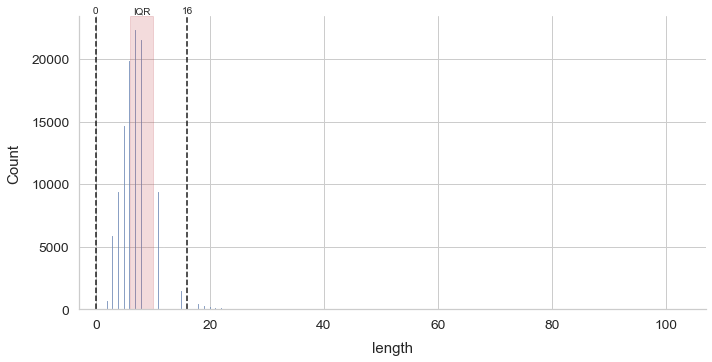

<IPython.core.display.Javascript object>

In [35]:
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["length"], g.axes[0, 0], num_format=".0f")

16 seems like a natural cutoff for word length, and it's what Tukey's IQR proximity rule dictates. I'll enforce this cutoff with my tokenizer. Once I tokenize the text, I can simply join and split with space.

In [36]:
# Tokenize
df["text"] = regex_tokenize(df.loc[:, "text"], pattern=r"(?i)[a-z_]{2,16}", n_jobs=-1)
df["text"].head()

regex_tokenize:   0%|          | 0/1072953 [00:00<?, ?it/s]

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, xl, deluxe, reflex, action, cord, co...
B000050B63    [norelco, xl, quadra, action, cord, cordless, ...
B000050B64    [norelco, xl, quadra, action, cord, cordless, ...
B000050B65    [norelco, xl, deluxe, quadra, action, cord, co...
Name: text, dtype: object

<IPython.core.display.Javascript object>

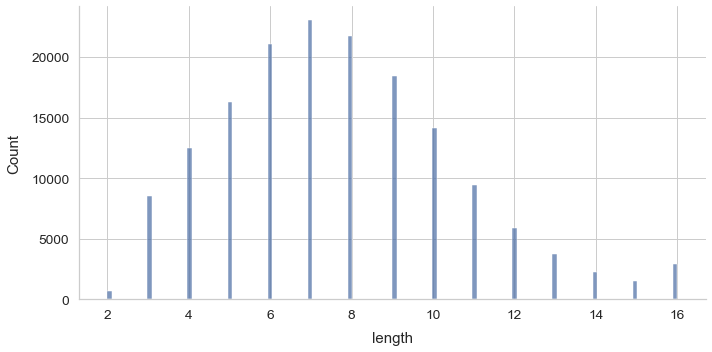

<IPython.core.display.Javascript object>

In [37]:
# Draw new sample
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5)

# Plot length distribution
g = sns.displot(data=samp_vocab, x="length", kind="hist", aspect=2)

A related source of noise are strings with repetitive character (or word) sequences.

In [38]:
samp_vocab.sort_values("uniq_ratio").head(10)

,term,freq,length,uniq_ratio
141128,zzzzzzzz,1,8,0.125000
151661,ffffff,1,6,0.166667
99911,xxxxx,1,5,0.200000
116322,noooooooo,1,9,0.222222
108258,zzzz,1,4,0.250000
91014,mmmm,2,4,0.250000
46540,xxxx,7,4,0.250000
161814,oraoraoraora,1,12,0.250000
117743,cyaaaaaaaaaaaann,1,16,0.250000
113761,cccc,1,4,0.250000


<IPython.core.display.Javascript object>

The above terms with repetitive sequences have low character uniqueness ratios, i.e. the ratio of character types to character tokens. That's how I'll filter them out.

Note: long multi-word amalgamations also have low character uniqueness simply because of their length, but I've already weeded those out.

<AxesSubplot:xlabel='uniq_ratio', ylabel='Count'>

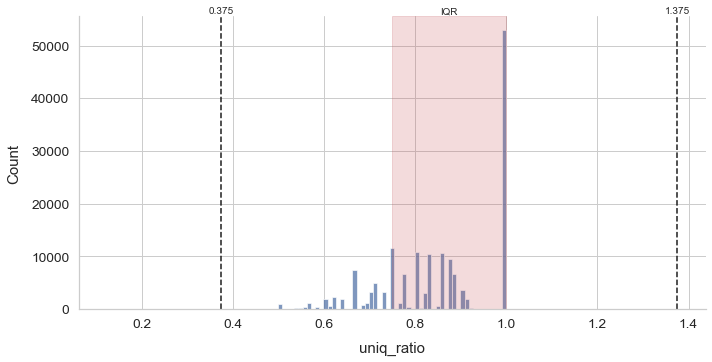

<IPython.core.display.Javascript object>

In [39]:
g = sns.displot(data=samp_vocab, x="uniq_ratio", kind="hist", aspect=2)
plotting.add_tukey_marks(samp_vocab["uniq_ratio"], g.axes[0, 0], num_format=".3f")

The lower Tukey fence is located at 0.375. That seems like a reasonable cutoff.

In [40]:
# Remove low uniqueness ratios
df["text"] = lang.uniq_char_thresh(df.loc[:, "text"], thresh=0.375)
df["text"].head()

uniq_char_thresh:   0%|          | 0/1072953 [00:00<?, ?it/s]

asin
B000050AUH    [philips, sonicare, standard, brush, head, son...
B000050B62    [norelco, xl, deluxe, reflex, action, cord, co...
B000050B63    [norelco, xl, quadra, action, cord, cordless, ...
B000050B64    [norelco, xl, quadra, action, cord, cordless, ...
B000050B65    [norelco, xl, deluxe, quadra, action, cord, co...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [41]:
samp_vocab = build_sample_vocab(df.loc[:, "text"], 10 ** 5)
samp_vocab.sort_values("uniq_ratio").head(10)

,term,freq,length,uniq_ratio
37836,reengineering,11,13,0.384615
121445,mirrormirrors,1,13,0.384615
136492,eminentemente,1,13,0.384615
84844,maaaa,2,5,0.400000
106113,nnooo,1,5,0.400000
69858,nanna,3,5,0.400000
5848,sleeveless,349,10,0.400000
120679,xxiii,1,5,0.400000
76386,sassafrass,2,10,0.400000
140979,seese,1,5,0.400000


<IPython.core.display.Javascript object>

Looks better. If I raise the threshold more, I'll begin to filter out too many normal words.

In [42]:
data_checkpoint(df, "data/filters_checkpoint")

36 files created.


<IPython.core.display.Javascript object>

## Restricting to English

Next I run [langdetect](https://pypi.org/project/langdetect/) (a Google language detection algorithm) on the documents and select only the English product descriptions. I have nothing against the other languages, but there are not enough examples of them in the dataset to build a truly multilingual model. I don't want the model to associate Spanish words with 'amazon fashion', for example. That would generalize poorly.

This cell takes 30-40 minutes to run if `RUN_LANGDETECT` is set.

In [43]:
if RUN_LANGDETECT:
    # Wrapper of `langdetect.detect` with multiprocessing
    df["lang"] = lang.detect_lang(df.loc[:, "text"].str.join(" "), seed=0, n_jobs=-1)
    df["lang"].to_json("data/langdetect.json")
else:
    # Load previous results
    df["lang"] = pd.read_json("data/langdetect.json", typ="series")

    # Run on difference
    missing = df["lang"].isna()
    if missing.any():
        df.loc[missing, "lang"] = lang.detect_lang(
            df.loc[missing, "text"].str.join(" "), seed=51, n_jobs=-1,
        )
        # Save new results
        df["lang"].to_json("data/langdetect.json")

df["lang"].value_counts()

en    1070668
es        988
fr        200
it        200
pt        133
no        117
nl        116
de        112
da         84
id         56
ca         49
sv         39
af         29
ro         25
pl         22
so         19
sl         12
tl         12
hr         10
cs         10
sw         10
lt          9
et          7
cy          7
tr          5
hu          5
fi          3
sk          2
sq          2
vi          1
lv          1
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [44]:
df = df.loc[df.lang == "en"].copy()
df["lang"].value_counts()

en    1070668
Name: lang, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
len(df)

1070668

<IPython.core.display.Javascript object>

## Lemmatizing

Next I lemmatize the text using my wrapper around `nltk.WordnetLemmatizer`. Lemmatizing will increase the generalizability of the model by making the vocabulary more coarse-grained. There is no need for the model to learn the details about every different form of a word.

In [49]:
help(lang.wordnet_lemmatize)

Help on function wordnet_lemmatize in module tools.language.processors.tokens:

wordnet_lemmatize(tokens: Union[Collection[str], Collection[Collection[str]]], *, preserve: Iterable[str] = None, n_jobs=None) -> Union[Collection[str], Collection[Collection[str]]]
    Reduce English words to root form using Wordnet.
    
    Tokens are first tagged with parts of speech and then
    lemmatized accordingly.
    
    Parameters
    ----------
    tokens : sequence of str
        Tokens to lemmatize.
    
    Returns
    -------
    Sequence of str
        Lemmatized tokens.



<IPython.core.display.Javascript object>

As the docstring for my `lang.wordnet_lemmatize` indicates, words are tagged with parts of speech before they are lemmatized. PoS tagging is not a built-in feature of `nltk.WordnetLemmatizer` even though tags are required for proper lemmatization. An additional wrinkle is that the tags obtained from `nltk.pos_tag` need to be translated into Wordnet tags.

Accordingly, there is very much a need for my wrapper function. And I've parallelized it, since lemmatization is slow. Unfortunately, it still takes about 45 minutes.

In [8]:
df["text"] = lang.wordnet_lemmatize(df["text"], n_jobs=-1)
df["text"].head()

wordnet_lemmatize:   0%|          | 0/1072953 [00:00<?, ?it/s]

asin
B000050AUH    [philip, sonicare, standard, brush, head, soni...
B000050B62    [norelco, xl, deluxe, reflex, action, cord, co...
B000050B63    [norelco, xl, quadra, action, cord, cordless, ...
B000050B64    [norelco, xl, quadra, action, cord, cordless, ...
B000050B65    [norelco, xl, deluxe, quadra, action, cord, co...
Name: text, dtype: object

<IPython.core.display.Javascript object>

In [11]:
data_checkpoint(df, "data/lemmatize_checkpoint")

36 files created.


<IPython.core.display.Javascript object>

## Removing Stopwords

Before searching for collocations, I want to remove stopwords. As you can see below, there are quite a few in the vocabulary.

In [7]:
samp_vocab = build_sample_vocab(df["text"], 10 ** 4, sortby="freq")
samp_vocab.head(10)

,term,freq,length,uniq_ratio
0,the,72215,3,1.0
1,and,66234,3,1.0
2,be,39918,2,1.0
3,to,39019,2,1.0
4,of,35879,2,1.0
5,for,27932,3,1.0
6,with,26381,4,1.0
7,in,25461,2,1.0
8,your,14661,4,1.0
9,this,12591,4,1.0


In [23]:
# Fetch stopwords
stop = lang.fetch_stopwords("nltk_english")
pprint(stop, compact=True)

{'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an',
 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been',
 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
 "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't",
 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from',
 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
 "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's",
 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor',
 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't",
 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", '

I add some more domain-specific stopwords.

In [24]:
stop.update(
    [
        "additional",
        "address",
        "addresses",
        "apo",
        "asin",
        "best",
        "buy",
        "cash",
        "com",
        "customer",
        "deal",
        "deliver",
        "delivered",
        "delivery",
        "detail",
        "dimensions",
        "discontinued",
        "eligible",
        "feature",
        "fpo",
        "guarantee",
        "item",
        "listed",
        "money",
        "na",
        "none",
        "package",
        "ounce",
        "ounces",
        "pound",
        "pounds",
        "premium",
        "price",
        "product",
        "purchase",
        "quality",
        "review",
        "reviewed",
        "reviewer",
        "reviews",
        "sale",
        "sales",
        "save",
        "savings",
        "ship",
        "ships",
        "shipment",
        "shipments",
        "shipped",
        "shipper",
        "shipping",
        "specification",
        "support",
        "value",
        "weight",
        "within",
    ]
)

pprint(stop, compact=True)

{'a', 'about', 'above', 'additional', 'address', 'addresses', 'after', 'again',
 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren',
 "aren't", 'as', 'asin', 'at', 'be', 'because', 'been', 'before', 'being',
 'below', 'best', 'between', 'both', 'but', 'buy', 'by', 'can', 'cash', 'com',
 'couldn', "couldn't", 'customer', 'd', 'deal', 'deliver', 'delivered',
 'delivery', 'detail', 'did', 'didn', "didn't", 'dimensions', 'discontinued',
 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during',
 'each', 'eligible', 'feature', 'few', 'for', 'fpo', 'from', 'further',
 'guarantee', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
 "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's",
 'item', 'its', 'itself', 'just', 'listed', 'll', 'm', 'ma', 'me', 'mightn',
 "mightn't", 'money', 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'na'

In [25]:
# Run through tokenizer
stop = set(regex_tokenize(" ".join(stop)))

pprint(stop, compact=True)

{'about', 'above', 'additional', 'address', 'addresses', 'after', 'again',
 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'apo', 'are', 'aren', 'as',
 'asin', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'best',
 'between', 'both', 'but', 'buy', 'by', 'can', 'cash', 'com', 'couldn',
 'customer', 'deal', 'deliver', 'delivered', 'delivery', 'detail', 'did',
 'didn', 'dimensions', 'discontinued', 'do', 'does', 'doesn', 'doing', 'don',
 'down', 'during', 'each', 'eligible', 'feature', 'few', 'for', 'fpo', 'from',
 'further', 'guarantee', 'had', 'hadn', 'has', 'hasn', 'have', 'haven',
 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his',
 'how', 'if', 'in', 'into', 'is', 'isn', 'it', 'item', 'its', 'itself', 'just',
 'listed', 'll', 'ma', 'me', 'mightn', 'money', 'more', 'most', 'mustn', 'my',
 'myself', 'na', 'needn', 'no', 'none', 'nor', 'not', 'now', 'of', 'off', 'on',
 'once', 'only', 'or', 'other', 'ounce', 'ounces', 'our', 'ours', 'ourselves',


In [26]:
with open("canonical_params/stopwords.json", "w") as f:
    json.dump(list(stop), f)

In [27]:
df["text"] = lang.remove_stopwords(df["text"], stop, n_jobs=-1)

remove_stopwords:   0%|          | 0/1072953 [00:00<?, ?it/s]

In [28]:
# Stitch tokens back together
df["text"] = df["text"].str.join(" ")
df["text"].head()

asin
B000050AUH    philip sonicare standard brush head sonic wave...
B000050B62    norelco xl deluxe reflex action cord cordless ...
B000050B63    norelco xl quadra action cord cordless recharg...
B000050B64    norelco xl quadra action cord cordless recharg...
B000050B65    norelco xl deluxe quadra action cord cordless ...
Name: text, dtype: object

In [29]:
data_checkpoint(df, "data/stopwords_checkpoint")

Overwriting...
36 files created.


## Multi-word Expressions

I already have a lot of high quality brand phrases which I expect to be strong features for the model. I'll go ahead and prepare those.

Recall that there are still some ultra-rare brands in the dataset. I don't care about turning those into phrases, so I slice out brands with at least 10 products.

In [33]:
brand_ng = pd.Series(df["brand"].value_counts().loc[lambda x: x >= 10].index)
brand_ng = brand_ng.str.split("_")
brand_ng = brand_ng.loc[brand_ng.str.len() > 1]
brand_ng

2                     [yu, gi, oh]
3          [magic, the, gathering]
7             [amazon, collection]
8               [various, artists]
12                 [evan, fischer]
                   ...            
8785                [herbie, mann]
8786                [jimmy, smith]
8789           [gilbert, sullivan]
8791             [marco, beltrami]
8792    [unopened, box, of, packs]
Length: 6558, dtype: object

Next I lemmatize the brand phrase components to match the preprocessing of the text.

In [34]:
brand_ng = lang.remove_stopwords(brand_ng, stop)
brand_ng = lang.wordnet_lemmatize(brand_ng).map(tuple)
brand_ng

remove_stopwords:   0%|          | 0/6558 [00:00<?, ?it/s]

wordnet_lemmatize:   0%|          | 0/6558 [00:00<?, ?it/s]

2                (yu, gi, oh)
3          (magic, gathering)
7        (amazon, collection)
8           (various, artist)
12            (evan, fischer)
                ...          
8785           (herbie, mann)
8786           (jimmy, smith)
8789      (gilbert, sullivan)
8791        (marco, beltrami)
8792    (unopened, box, pack)
Length: 6558, dtype: object

Next I stitch the tokens back together so I can run the text through my n-gram search function.

I search for collocations in the text in a stratified fashion, scanning the documents of each 'main_cat' category as a separate corpus. The goal is to find n-grams which are peculiar to each category. I use pointwise mutual information (PMI) to identify bigrams.

In [40]:
cat_bg = lang.stratified_ngrams(
    df,
    n=2,
    text="text",
    # Stratify by 'main_cat'
    cat="main_cat",
    # Space-tokenize
    tokenizer=lambda x: x.split(),
    # Use pointwise mutual information
    metric="pmi",
    # Select top 50% of scores in each category
    select_best=0.5,
    # Filter out ultra-rare ngrams
    min_freq=100,
    n_jobs=-1,
)
cat_bg

,bigram,score,main_cat
0,"(tom, maine)",9.677467,all beauty
1,"(diamond, fx)",8.997491,all beauty
2,"(old, spice)",8.993194,all beauty
3,"(year, warranty)",8.968578,all beauty
4,"(pro, health)",8.878108,all beauty
...,...,...,...
80345,"(high, speed)",6.351686,video games
80346,"(intuitive, control)",6.342523,video games
80347,"(test, skill)",6.319361,video games
80348,"(special, effect)",6.292870,video games


In [44]:
# Merge ngrams into single list
phrases = cat_bg["bigram"].append(brand_ng).drop_duplicates().to_list()
display(len(phrases))
pprint(phrases[:100], compact=True)

71547

[('tom', 'maine'), ('diamond', 'fx'), ('old', 'spice'), ('year', 'warranty'),
 ('pro', 'health'), ('philip', 'sonicare'), ('ovp', 'ocp'), ('hisense', 'sero'),
 ('pittsburgh', 'steelers'), ('hello', 'kitty'), ('barnes', 'noble'),
 ('emc', 'retrospect'), ('unspsc', 'codeunspsc'), ('headquarter', 'irvine'),
 ('ushio', 'phoenix'), ('fov', 'numerical'), ('incur', 'attempt'),
 ('cannot', 'massachusetts'), ('beach', 'florida'), ('unite', 'scope'),
 ('biology', 'metallurgy'), ('found', 'headquarter'), ('medical', 'forensic'),
 ('osram', 'ushio'), ('nature', 'misuse'), ('altec', 'lansing'),
 ('facility', 'west'), ('emi', 'rfi'), ('research', 'biology'),
 ('cigarette', 'lighter'), ('forensic', 'science'), ('science', 'veterinary'),
 ('daisy', 'chain'), ('helvetica', 'neue'), ('neue', 'arial'),
 ('verdana', 'helvetica'), ('bi', 'directional'), ('lenovo', 'ideatab'),
 ('mains', 'psu'), ('inspection', 'dissection'), ('sans', 'serif'),
 ('fe', 'fe'), ('dcr', 'trv'), ('nex', 'nex'), ('lenovo', 'ideap

In [45]:
with open("canonical_params/phrases.json", "w") as f:
    json.dump(phrases, f)

In [46]:
del cat_bg, brand_ng

In [47]:
ngram_tokenize = nltk.MWETokenizer(phrases).tokenize
ngram_tokenize

<bound method MWETokenizer.tokenize of <nltk.tokenize.mwe.MWETokenizer object at 0x0000010836D57A60>>

In [48]:
df["text"] = df["text"].str.split()
df["text"].head()

asin
B000050AUH    [philip, sonicare, standard, brush, head, soni...
B000050B62    [norelco, xl, deluxe, reflex, action, cord, co...
B000050B63    [norelco, xl, quadra, action, cord, cordless, ...
B000050B64    [norelco, xl, quadra, action, cord, cordless, ...
B000050B65    [norelco, xl, deluxe, quadra, action, cord, co...
Name: text, dtype: object

In [49]:
# Join n-grams with underscore
df["text"] = [ngram_tokenize(x) for x in tqdm(df["text"], "ngram_tokenize")]

df["text"].head()

ngram_tokenize:   0%|          | 0/1072953 [00:00<?, ?it/s]

asin
B000050AUH    [philip_sonicare, standard, brush_head, sonic,...
B000050B62    [norelco, xl, deluxe, reflex, action, cord, co...
B000050B63    [norelco, xl, quadra, action, cord, cordless, ...
B000050B64    [norelco, xl, quadra, action, cord, cordless, ...
B000050B65    [norelco, xl, deluxe, quadra, action, cord, co...
Name: text, dtype: object

In [50]:
df["text"] = df["text"].str.join(" ")
df["text"].head()

asin
B000050AUH    philip_sonicare standard brush_head sonic wave...
B000050B62    norelco xl deluxe reflex action cord cordless ...
B000050B63    norelco xl quadra action cord cordless recharg...
B000050B64    norelco xl quadra action cord cordless recharg...
B000050B65    norelco xl deluxe quadra action cord cordless ...
Name: text, dtype: object

In [51]:
data_checkpoint(df, "data/model_data")

Overwriting...
36 files created.


Before I move on to modeling, I plot the final class balance.

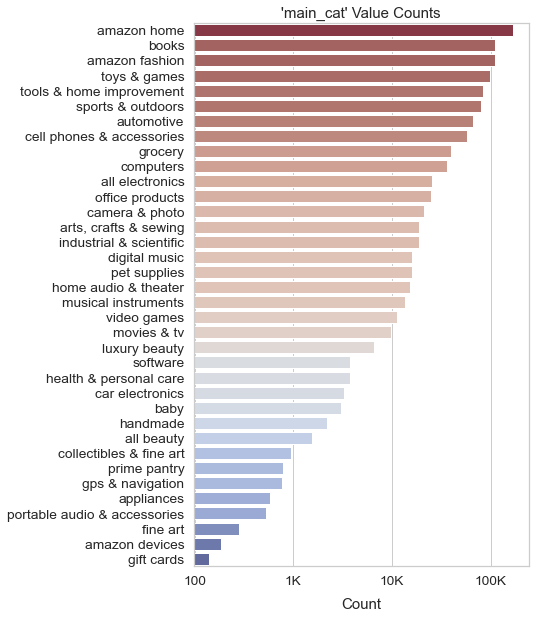

In [52]:
ax = plotting.plots.countplot(df["main_cat"], size=(6, 10), log_scale=True)
ax.xaxis.set_major_formatter(plotting.big_number_formatter())
ax.figure.savefig(
    "figures/class_bal.svg", bbox_inches="tight",
)


# Modeling
## Performing the Split

In [3]:
df = pd.read_parquet("data/model_data", engine="pyarrow")
df.head()

,text,title,brand,lang,main_cat
asin,,,,,
B000050AUH,philip_sonicare standard brush_head sonic wave...,philips sonicare standard brush head,philips_sonicare,en,all beauty
B000050B62,norelco xl deluxe reflex action cord cordless ...,norelco 5841xl deluxe reflex action cord/cordl...,norelco,en,all beauty
B000050B63,norelco xl quadra action cord cordless recharg...,norelco 6826xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B64,norelco xl quadra action cord cordless recharg...,norelco 6865xl quadra action cord/cordless rec...,norelco,en,all beauty
B000050B65,norelco xl deluxe quadra action cord cordless ...,norelco 6885xl deluxe quadra action cord/cordl...,norelco,en,all beauty


In [4]:
X = df.loc[:, "text"]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((715693,), (238565,), (715693,), (238565,))

Next, I create the vectorizer. I have a taste for interpretability and transparency, which is why I've opted to use term-frequency vectorization (e.g. binary occurrence, raw term-frequency, or TF\*IDF). For the baseline model, I turn off IDF weighting and normalization. Therefore, `tf` is initially set to extract raw term-frequency vectors from the text.

In [5]:
tf = TfidfVectorizer(
    lowercase=False,
    # Space tokenize
    token_pattern=r"\S+",
    norm=None,
    use_idf=False,
)

tf

TfidfVectorizer(lowercase=False, norm=None, token_pattern='\\S+', use_idf=False)

I've opted to use Scikit-Learn's `SGDClassifier` because it's efficient on large datasets and works with several different loss functions. Essentially, it offers widely used linear classifiers with stochastic gradient descent optimization.

I could have also chosen a neural network classifier such as Scikit-Learn's ready-made multi-layer perceptron. However, neural networks take a long time to train and are the least interpretable algorithms on the market. For this project, given my limited computational resources and personal tastes, I've opted for a more traditional approach.

In [6]:
sgd = SGDClassifier(loss="hinge", class_weight="balanced", n_jobs=-1,)

sgd

SGDClassifier(class_weight='balanced', n_jobs=-1)

The default loss function 'hinge' is a linear support vector classifier. `SGDClassifier` also offers squared hinge, logistic regression, modified Huber, and several losses designed for regression.

Next, I create a pipeline containing just two steps: the vectorizer and the classifier.

In [7]:
pipe = Pipeline([("vec", tf), ("cls", sgd),], verbose=True,)
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='\\S+', use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

The [User Guide](https://scikit-learn.org/stable/modules/sgd.html#sgd) emphasizes that `SGDClassifier` is sensitive to feature scale. However, since word frequencies are already on the same scale, there is no need to include a scaler.

A related concern is vector normalization (sample scale). The User Guide states that the default learning rate formula (`learning_rate='optimal'`) assumes "that the norm of the training samples is approx. 1." Another reason to normalize the vectors is to minimize the effect of document length. Again, I've turned it off for the baseline, but I fully expect to turn it back on later.

Next I define some functions which I'll use throughout the modeling process.

In [8]:
def plot_confusion_matrix(
    estimator,
    X_test=X_test,
    y_test=y_test,
    dst=None,
    xticks_rotation="vertical",
    **kwargs,
):
    """Plots confusion matrix with accuracy score."""
    ax = plotting.confusion_matrix(
        estimator, X_test, y_test, xticks_rotation=xticks_rotation, **kwargs,
    )
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    ax.set_title(f"Accuracy: {acc:.2f}, Balanced Accuracy: {bal_acc:.2f}", pad=5)
    if isinstance(dst, str):
        plt.savefig(dst, bbox_inches="tight")
    return ax

In [9]:
def get_report(estimator, X_test=X_test, y_test=y_test):
    """Returns standard classification metrics as a DataFrame."""
    report = classification_report(y_test, estimator.predict(X_test), output_dict=True)
    report = pd.DataFrame(report).T
    report.loc["accuracy", "support"] = report["support"].max()
    return report

In [10]:
def extract_coef(
    pipeline, classifier="cls", vectorizer="vec",
):
    """Returns labeled model coefficients as a DataFrame."""
    columns = np.array(pipeline[vectorizer].get_feature_names())
    coef = pd.DataFrame(
        pipeline[classifier].coef_,
        index=pipeline[classifier].classes_,
        columns=columns,
    ).T
    return coef

## Fitting the Baseline

Without further ado, it's time to fit the baseline model.

In [11]:
if "svm_1" in FIT_MODELS:
    # Train the model (slow)
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_1.joblib", compress=True)

else:
    # Load the saved model (fast)
    pipe = joblib.load("models/svm_1.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(lowercase=False, norm=None,
                                 token_pattern='\\S+', use_idf=False)),
                ('cls', SGDClassifier(class_weight='balanced', n_jobs=-1))],
         verbose=True)

Since these models take a couple minutes to train, I always save them so they can be quickly reloaded.

In [12]:
len(pipe["vec"].get_feature_names())

C:\Users\ndgig\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


545153

550K features is a lot, but not bad considering the size of the dataset. I'm sure it would've been much larger if not for my extensive preprocessing efforts.

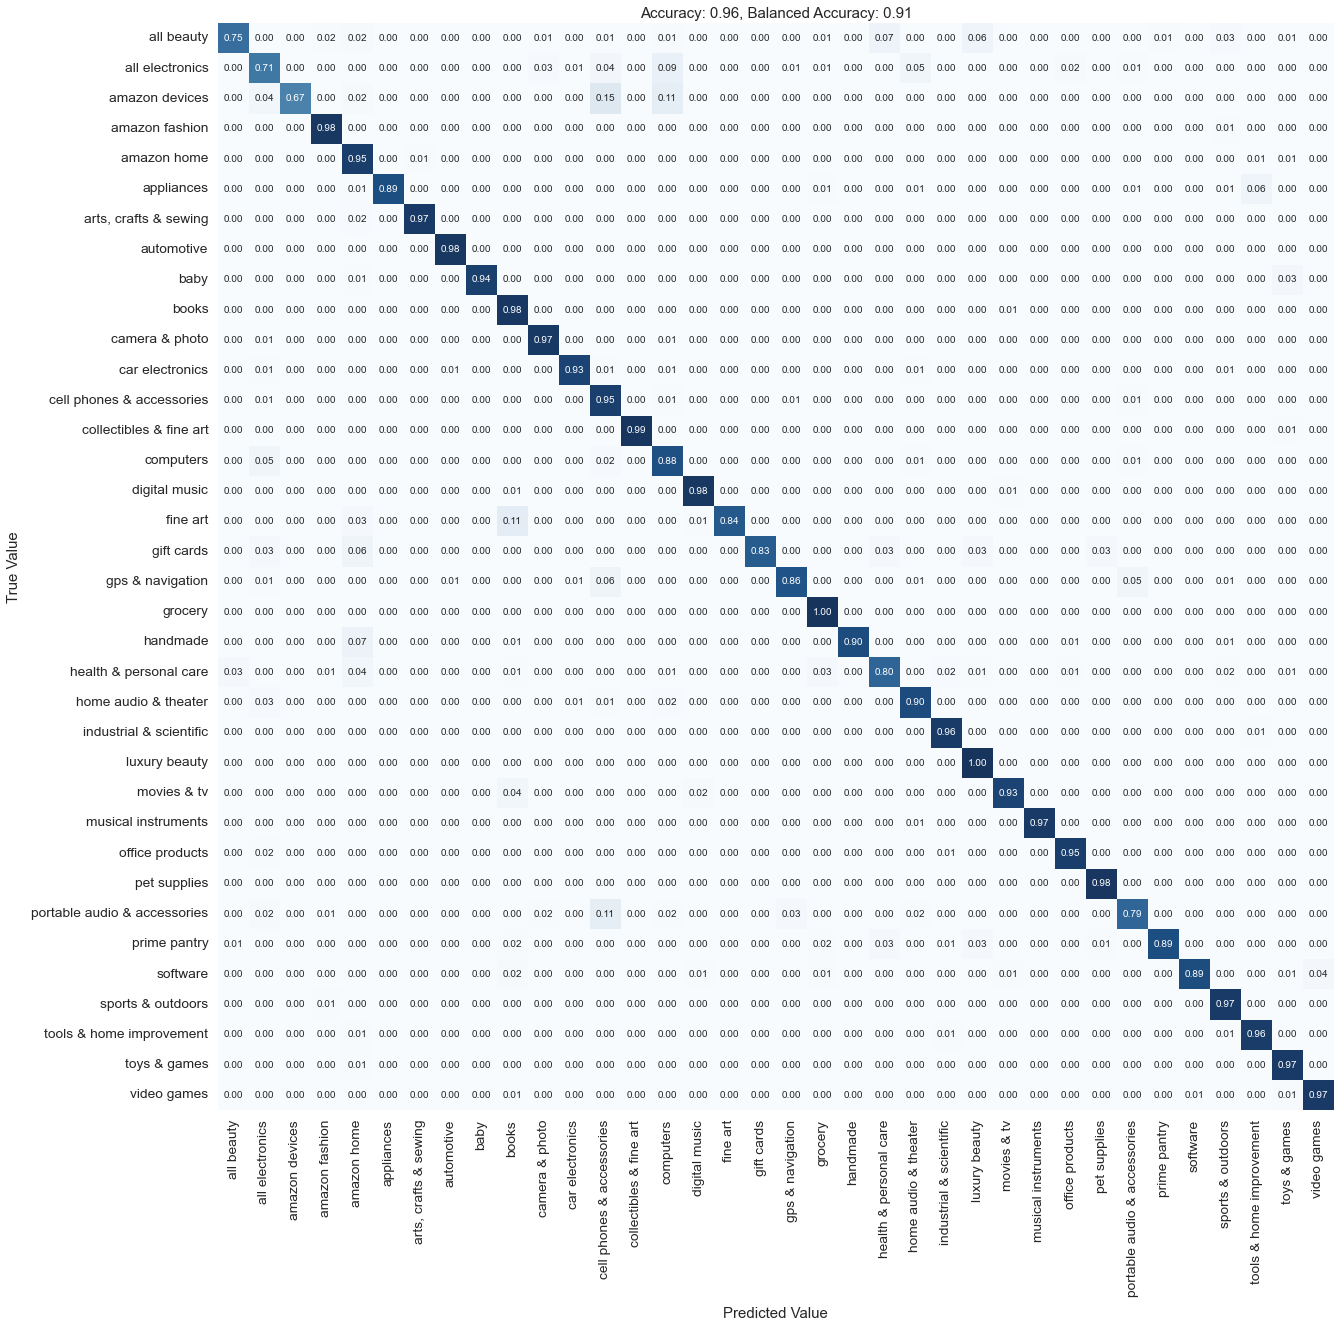

In [13]:
name = "svm_1"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

Not bad for a baseline! Is it too good to be true, or have my painstaking efforts simply paid off? Let's look at the coefficients.

In [14]:
coef = extract_coef(pipe)
coef.sort_values("all electronics", ascending=False).head(10)

,all beauty,all electronics,amazon devices,amazon fashion,amazon home,appliances,"arts, crafts & sewing",automotive,baby,books,...,musical instruments,office products,pet supplies,portable audio & accessories,prime pantry,software,sports & outdoors,tools & home improvement,toys & games,video games
riorand,-0.012425,1.353176,-0.001657,-0.024850,-0.112958,-0.004970,-0.006212,-0.017084,0.000000,0.000000,...,-0.037275,-0.009319,-0.028399,-0.013018,0.000000,-0.003106,-0.009940,-0.166498,-0.075931,-0.024850
kenable,0.000000,1.034394,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018637,0.000000,0.000000,...,-0.130461,-0.003106,0.000000,0.000000,0.000000,0.000000,-0.003728,-0.014910,-0.035895,0.000000
amscope,-0.013806,1.009252,-0.003314,0.000000,-0.025980,-0.002485,-0.003106,-0.012425,0.000000,0.000000,...,-0.018637,-0.001553,-0.010650,-0.001183,0.000000,0.000000,-0.048458,-0.034791,-0.009664,0.000000
javoedge,-0.011044,0.962037,0.537519,0.000000,-0.011296,-0.002485,-0.003106,0.000000,-0.006212,-0.016567,...,-0.006212,-0.003106,-0.003550,-0.075148,0.000000,-0.007766,0.000000,-0.002485,-0.002761,-0.003106
thermaltake,-0.005522,0.873513,-0.004970,0.000000,-0.013555,-0.018638,-0.007766,-0.054359,0.000000,-0.011044,...,0.000000,-0.023297,-0.007100,-0.001775,0.000000,0.000000,-0.041003,-0.022365,0.000000,-0.003106
ocz,0.000000,0.866233,-0.003314,0.000000,0.002172,-0.004970,-0.001553,0.000000,0.000000,0.000000,...,-0.034168,0.000000,-0.001775,-0.028402,0.000000,-0.006212,-0.032306,-0.003728,0.000000,-0.031062
trendnet,0.000000,0.863738,-0.004970,0.000000,-0.003389,0.000000,0.000000,0.000000,0.000000,-0.013806,...,-0.012425,0.000000,0.000000,-0.006509,-0.002485,-0.006212,-0.003728,-0.009940,0.000000,0.000000
antec,0.000000,0.858823,0.000000,0.000000,-0.022592,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.069890,0.000000,0.000000,0.000000,0.000000,0.000000,-0.031063,-0.024850,0.000000,0.000000
silverstone,0.000000,0.842093,0.000000,0.002521,-0.037110,-0.003728,0.069553,-0.001553,0.000000,-0.006903,...,-0.010872,0.000000,0.000000,-0.001183,0.000000,0.000000,-0.007455,-0.021123,-0.005336,0.004135
pny,0.000000,0.827791,-0.001657,0.000000,0.000000,0.000000,-0.006212,-0.017084,0.000000,0.000000,...,0.000000,0.004228,0.000000,-0.009467,0.000000,-0.145992,0.000000,0.000000,0.000000,-0.107164


The coefficients look just as I expected. Brand terms are at the top, at least for 'all electronics'. While I did filter out only the top 1% of brands for each category, there are still nearly 10,000 brands in the dataset. Moreover, these brand names are recognizable and make sense.

Next, it's time to choose the loss function.

## Selecting the Classifier

I try out all four of the classification loss functions: 'hinge', 'squared_hinge', 'log', and 'modified_huber'. I also tune the penalty and regularization strength, as well as the basic vectorizer settings.

In [15]:
sgd_grid = {
    "cls__loss": ["hinge", "squared_hinge", "log", "modified_huber"],
    "cls__penalty": ["l1", "l2"],
    "cls__alpha": sp.stats.loguniform(1e-8, 1e-2),
    "vec__use_idf": [True, False],
    "vec__binary": [True, False],
    "vec__norm": ["l1", "l2", None],
}

sgd_grid

{'cls__loss': ['hinge', 'squared_hinge', 'log', 'modified_huber'],
 'cls__penalty': ['l1', 'l2'],
 'cls__alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x211c02cc7c0>,
 'vec__use_idf': [True, False],
 'vec__binary': [True, False],
 'vec__norm': ['l1', 'l2', None]}

Given the size of the dataset, with `X_train` at around 800K samples, I opt for a randomized search with successive halving. It's essentially a survival-of-the-fittest contest between a set of randomly-selected parameter combinations. In the first round, the parameters are tested on 10K samples. With each successive round, the weak combinations are eliminated and the amount of data increases.

It's a more scalable approach than running an exhaustive search on the full `X_train`, though it still takes an hour or two. Note that I am optimizing **accuracy** while keeping an eye on "balanced accuracy" a.k.a. macro average (unweighted) recall. I'm mostly concerned with the overall ratio of correct classification, as long as the small classes are reasonably accommodated.

In [16]:
if "loss" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        sgd_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/loss_cv.joblib",
        kind="hrand",
        min_resources=10 ** 3,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    loss_results = gs.cv_results_
else:
    loss_results = joblib.load("sweeps/loss_cv.joblib")

loss_results = selection.prune_cv(loss_results)
loss_results.head(10)

,alpha,loss,penalty,binary,norm,use_idf,params,mean_fit_time,mean_score,rank_score
0,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",241.589407,0.963798,1
1,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",121.395599,0.953789,2
2,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",102.892204,0.949059,3
3,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",99.634805,0.947215,4
4,7.157636e-07,log,l2,False,l2,True,"{'cls__alpha': 7.15763577656479e-07, 'cls__los...",26.191196,0.935344,5
5,5.255038e-07,hinge,l2,True,l2,True,"{'cls__alpha': 5.25503769545935e-07, 'cls__los...",26.031597,0.933922,6
6,1.605315e-08,log,l2,False,l1,True,"{'cls__alpha': 1.6053147327650663e-08, 'cls__l...",28.755394,0.933267,7
7,3.082426e-06,hinge,l2,False,l2,False,"{'cls__alpha': 3.0824261182174037e-06, 'cls__l...",24.616992,0.928700,8
8,7.857063e-06,hinge,l2,False,l2,False,"{'cls__alpha': 7.857063428799315e-06, 'cls__lo...",23.931392,0.924689,9
9,4.430582e-08,log,l2,True,l1,True,"{'cls__alpha': 4.4305817166390654e-08, 'cls__l...",27.540397,0.924622,10


The default hinge loss wins, with logistic regression in a close second. L2 penalty looks to have completely dominated L1, and the top-scoring 'alpha' values are on the order of $10^7$ or $10^8$. Unsurprisingly, the vector normalization was selected (L2) and IDF weighting to reduce the impact of common terms. Binary occurrence was selected over term-frequency, which I wouldn't have predicted.

For each document and each term, the vectorizer will mark whether the term occurs in that document. Then the vectorizer will apply IDF (inverse document frequency) weighting to the binary features, placing weight on rare terms and withholding it from common ones. Then, finally, it will normalize the vectors to reduce the effect of document length (longer documents typically have a wider variety of terms, meaning more 1s in their vectors).

## Fitting a Linear SVM

The next step is to set the new parameters and fit the second version of the model.

In [17]:
loss_params = loss_results.loc[0, "params"]
display(loss_params)
pipe.set_params(**loss_params)

{'cls__alpha': 5.25503769545935e-07,
 'cls__loss': 'hinge',
 'cls__penalty': 'l2',
 'vec__binary': True,
 'vec__norm': 'l2',
 'vec__use_idf': True}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

In [18]:
if "svm_2" in FIT_MODELS:
    pipe.fit(X_train, y_train)
    joblib.dump(pipe, "models/svm_2.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_2.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07,
                               class_weight='balanced', n_jobs=-1))],
         verbose=True)

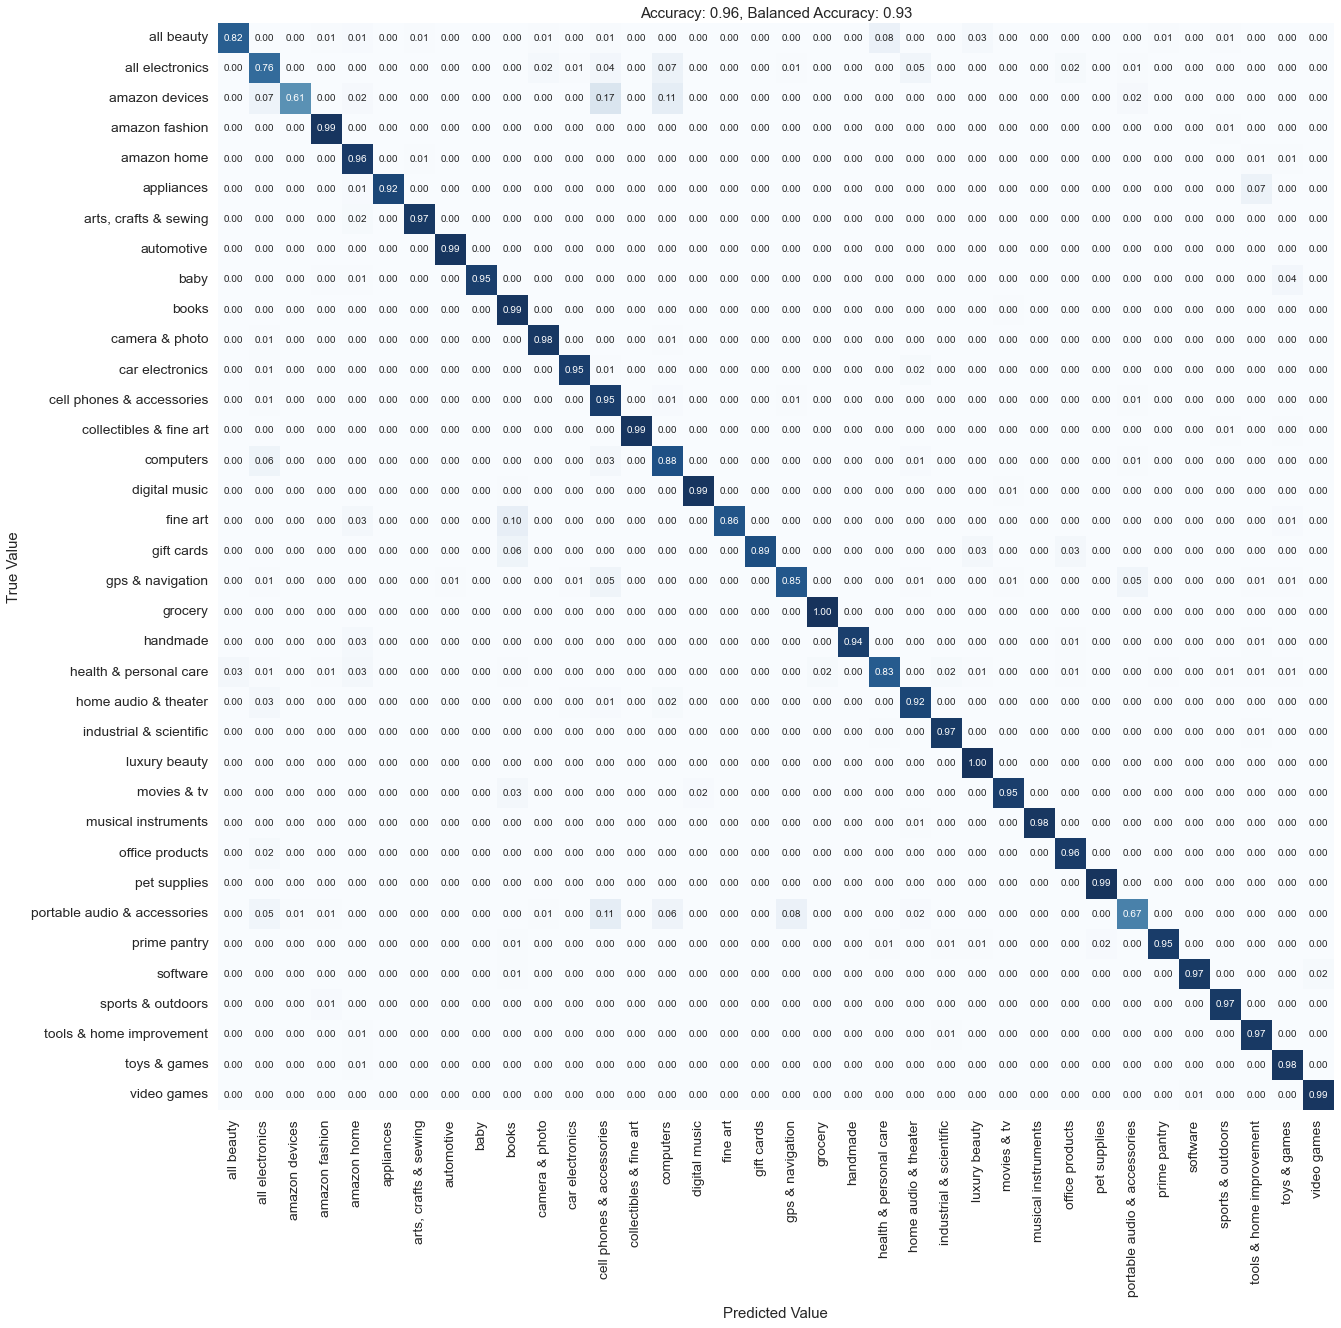

In [19]:
name = "svm_2"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

It looks like 'amazon devices' and 'portable audio & accessories' have the lowest recall. Amazon doesn't need this classifier for it's own proprietary devices, but 'portable audio' could be better. It's confused with 'cell phones & accessories' about 14% of the time.

Anyway, my focus is on overall accuracy, and I'm not interested in boosting the recall of small classes at the expense of large ones.

In [20]:
coef = extract_coef(pipe)
coef.sort_values("video games", ascending=False).head(10)

C:\Users\ndgig\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,all beauty,all electronics,amazon devices,amazon fashion,amazon home,appliances,"arts, crafts & sewing",automotive,baby,books,...,musical instruments,office products,pet supplies,portable audio & accessories,prime pantry,software,sports & outdoors,tools & home improvement,toys & games,video games
cta_digital,0.000000,-2.287251,-0.288938,-0.034282,-0.640243,0.000000,-0.068474,-0.396516,0.000000,0.000000,...,-0.768462,-0.274239,-0.043650,-0.094479,-0.071649,0.000000,-1.929040,-0.512276,-0.487332,10.285757
activision,0.000000,-0.653881,-0.055372,-0.155409,-0.155095,0.000000,0.000000,-0.403929,-0.042664,-1.953712,...,-0.799631,-0.049469,-0.680738,0.000000,0.000000,-1.864943,-2.741411,-0.343929,-4.153262,9.839858
ubisoft,-0.056999,-0.727405,0.000000,-0.207462,-0.413008,0.000000,-0.062191,-0.188662,0.000000,-2.348965,...,-0.130782,-0.059635,-0.054137,0.000000,0.000000,-2.861487,-0.795624,-0.067685,-3.035313,9.748822
electronic_art,0.000000,-0.738199,-0.018797,-0.129461,-1.122390,0.000000,0.000000,-0.290394,0.000000,-2.397817,...,0.000000,-0.165222,-0.361834,0.000000,-0.028985,-2.370393,-1.720411,-0.153169,-4.803345,9.590237
mad_catz,0.000000,-1.231500,-0.033992,0.000000,-0.356394,0.000000,0.000000,-0.137968,0.000000,0.000000,...,-2.201746,-0.066062,0.000000,0.000000,0.000000,-0.077591,-1.541142,-0.226286,-1.077951,9.273752
atari,0.000000,-0.780288,0.000000,-0.048574,-0.168974,0.000000,-0.041438,-0.276027,0.000000,-1.704980,...,-0.103574,-0.066021,0.000000,0.000000,0.000000,-2.307736,-1.469327,0.000000,-3.678920,9.243781
nintendo,-0.106857,-1.959147,-0.528799,-0.360567,-0.376450,-0.035396,-0.105711,-0.144174,-0.128108,-1.133541,...,-0.883624,-0.605751,-0.084794,-0.161826,0.000000,-1.100837,-1.751082,-0.044741,-3.026750,8.686562
sega,0.000000,-0.128832,-0.018473,-0.043056,-0.188335,0.000000,0.000000,0.050030,-0.097677,-1.928062,...,-0.215405,-0.112751,0.000000,-0.019667,0.000000,-0.589306,-1.722789,-0.150049,-2.573487,8.392604
thq,-0.040059,-0.186233,0.000000,0.000000,-0.045104,0.000000,0.000000,-0.335931,-0.177676,-1.891125,...,-0.177102,0.000000,-0.821684,-0.030141,0.000000,-0.701735,-0.662112,-0.108011,-4.023576,8.059435
mumbo_jumbo,0.000000,-0.087382,0.000000,-0.223802,-0.712913,0.000000,0.000000,0.000000,0.000000,-0.961663,...,0.000000,-0.113003,0.000000,0.000000,0.000000,-1.938434,0.356019,-0.064654,-1.872096,6.912669


Another successful coefficient sanity check. Nearly all of the top features for video games are recognizable brand names.

## Optimizing the Learning Rate

Next I'll optimize the learning rate for stochastic gradient descent. The default is 'optimal', which is a function of $\alpha$, the current time step $t$, and a heuristic value $t_0$.

The other options I'll try are 'constant' and 'adaptive'. As the name suggests, 'constant' is just the constant $eta_0$, which is passed as a hyperparameter. For 'adaptive', the initial learning rate is $eta_0$, but when the stopping criterion is reached, the learning rate is divided by 5 and the descent continues (defying the gods). The descent doesn't stop until the learning rate goes below $10^{-6}$.

In [21]:
learn_grid = [
    {
        "learning_rate": ["constant", "adaptive"],
        "eta0": sp.stats.loguniform(1e-4, 1e4),
        "average": [True, False],
    },
    {"learning_rate": ["optimal"], "average": [True, False],},
]
learn_grid

[{'learning_rate': ['constant', 'adaptive'],
  'eta0': <scipy.stats._distn_infrastructure.rv_frozen at 0x211d0fe4cd0>,
  'average': [True, False]},
 {'learning_rate': ['optimal'], 'average': [True, False]}]

In [22]:
if "learn" in RUN_SWEEPS:
    gs = selection.sweep(
        pipe,
        learn_grid,
        X=X_train,
        y=y_train,
        cv_dst="sweeps/learn_cv.joblib",
        kind="hrand",
        add_prefix="cls__",
        min_resources=10 ** 3,
        max_resources=X_train.shape[0],
        n_jobs=-1,
        factor=3,
    )
    learn_results = gs.cv_results_
else:
    learn_results = joblib.load("sweeps/learn_cv.joblib")

learn_results = selection.prune_cv(learn_results)
learn_results.head(10)

,average,eta0,learning_rate,params,mean_fit_time,mean_score,rank_score
0,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",2718.412539,0.964341,1
1,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",971.841199,0.954659,2
2,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",362.309605,0.954233,3
3,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",85.645006,0.952689,4
4,True,0.841666,adaptive,"{'cls__average': True, 'cls__eta0': 0.84166636...",289.311396,0.938111,5
5,False,1.656650,adaptive,"{'cls__average': False, 'cls__eta0': 1.6566501...",117.517600,0.937444,6
6,False,0.857235,constant,"{'cls__average': False, 'cls__eta0': 0.8572352...",36.053796,0.937389,7
7,False,1.925135,adaptive,"{'cls__average': False, 'cls__eta0': 1.9251349...",116.465399,0.936867,8
8,False,0.086955,constant,"{'cls__average': False, 'cls__eta0': 0.0869545...",26.184200,0.935878,9
9,False,0.081826,constant,"{'cls__average': False, 'cls__eta0': 0.0818255...",87.510197,0.935878,9


Looks like 'adaptive' wins, and with an epic fit time. The long fit time makes sense given the unyielding nature of the algorithm.

## Fitting the Final Model

Time to fit the third and final version of the model, now with 'adaptive' learning rate.

In [23]:
learn_params = learn_results.loc[0, "params"]
display(learn_params)
pipe.set_params(**learn_params)

{'cls__average': True,
 'cls__eta0': 0.8416663608926325,
 'cls__learning_rate': 'adaptive'}

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

In [24]:
if "svm_3" in FIT_MODELS:
    pipe.fit(X_train, y_train)

    joblib.dump(pipe, "models/svm_3.joblib", compress=True)

else:
    pipe = joblib.load("models/svm_3.joblib")
pipe

Pipeline(steps=[('vec',
                 TfidfVectorizer(binary=True, lowercase=False,
                                 token_pattern='\\S+')),
                ('cls',
                 SGDClassifier(alpha=5.25503769545935e-07, average=True,
                               class_weight='balanced', eta0=0.8416663608926325,
                               learning_rate='adaptive', n_jobs=-1))],
         verbose=True)

That took ~10 minutes to train, which is about 5x a long as the 'optimal' learning rate.

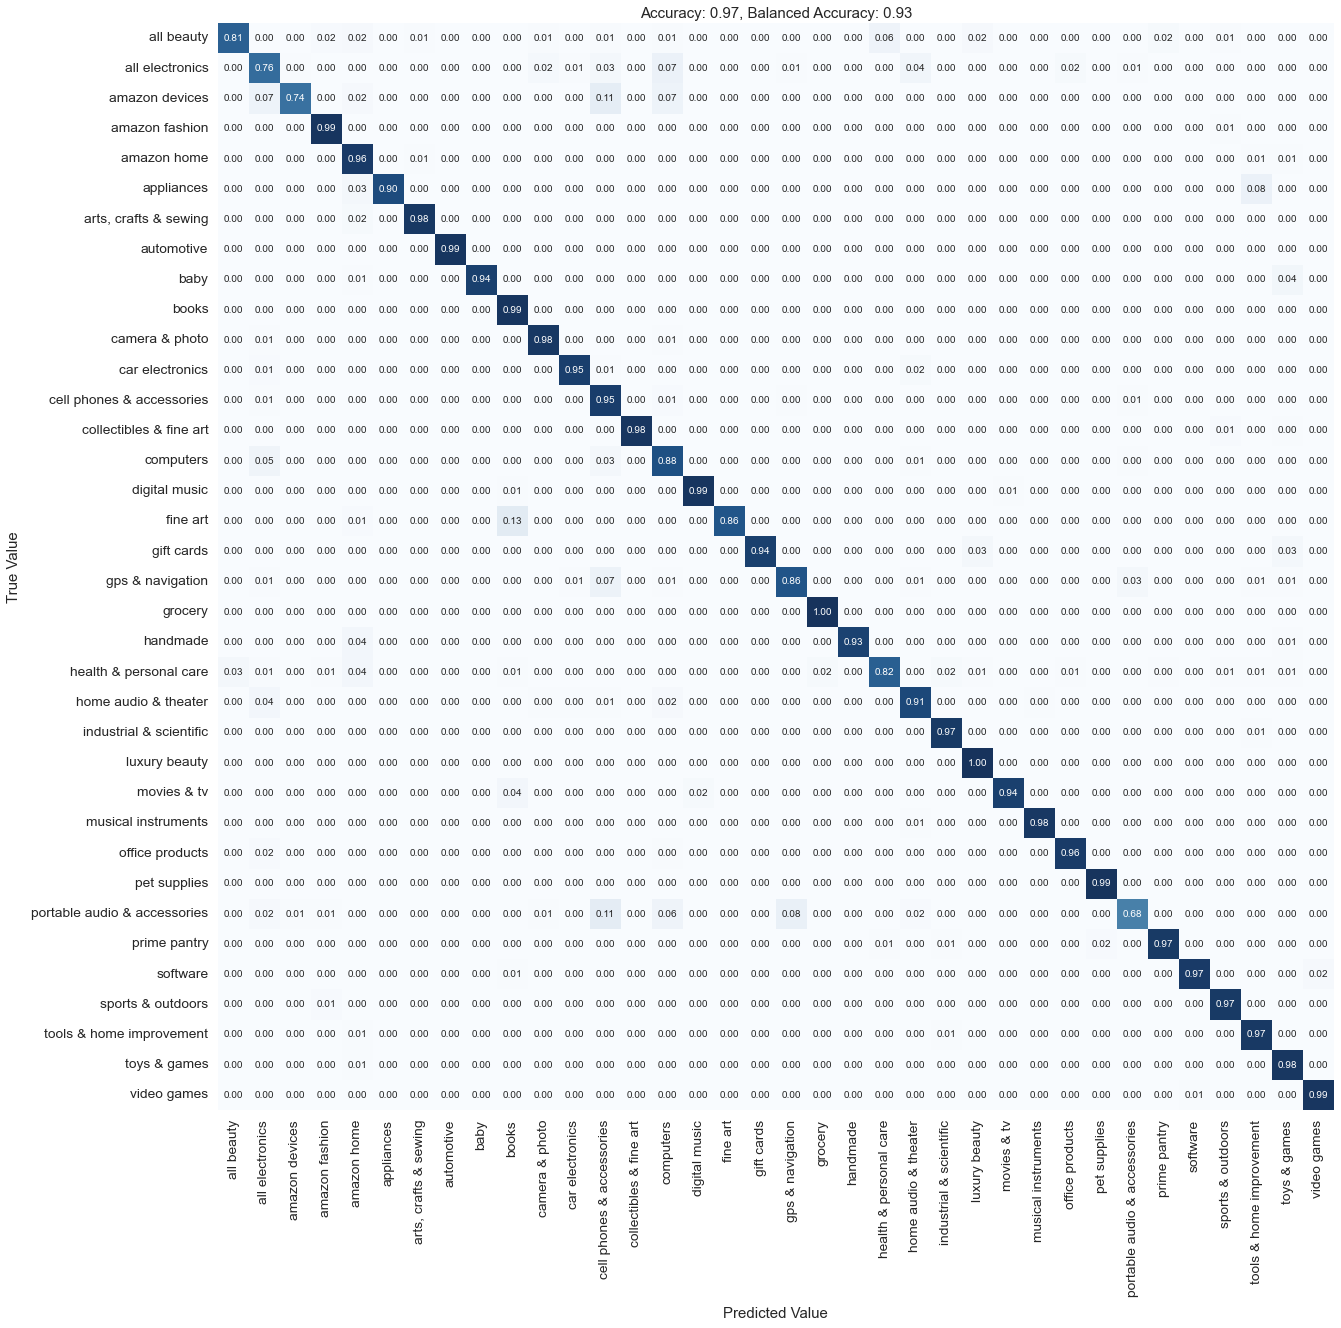

In [25]:
name = "svm_3"
if name in FIT_MODELS:
    ax = plotting.confusion_matrix(pipe, X_test, y_test, size=(20, 20))
    fig = ax.figure
    joblib.dump(fig, f"figures/{name}.joblib")

else:
    fig = joblib.load(f"figures/{name}.joblib")

fig.savefig(f"figures/{name}.svg", bbox_inches="tight")

It's up to 0.97 accuracy, and the balanced accuracy improved slightly. 0.97 accuracy is quite a satisfactory number, so I'll move on to interpretation.

# Interpreting the Results

The next step is to take a closer look at the final model's coefficients. I already know that brand terms are critically important, but I'd like to see which brands are associated with which categories. I'm also interested in discovering what non-brand terms made it to the top.

In [26]:
coef = extract_coef(pipe)
coef.columns = coef.columns.str.title()
coef.sort_values("Amazon Fashion", ascending=False).head(20)

C:\Users\ndgig\anaconda3\envs\capstone\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,All Beauty,All Electronics,Amazon Devices,Amazon Fashion,Amazon Home,Appliances,"Arts, Crafts & Sewing",Automotive,Baby,Books,...,Musical Instruments,Office Products,Pet Supplies,Portable Audio & Accessories,Prime Pantry,Software,Sports & Outdoors,Tools & Home Improvement,Toys & Games,Video Games
dimension_inch,-3.541355,-0.246294,1.428566,7.155133,-1.732445,-1.360537,-1.217614,-1.158463,0.213434,-2.377944,...,-0.478285,-1.046926,-0.139362,1.570464,-0.732782,-0.620147,-3.768887,-0.444776,-5.462269,-0.156341
port_authority,-0.096907,0.456576,0.000000,5.630484,-0.429961,0.000000,-0.222466,-0.003754,0.000000,-0.152970,...,0.000000,-0.085520,-0.044419,0.000000,-0.016089,0.000000,-3.955513,-0.306449,-0.061956,-0.021261
sport_tek,0.000000,-0.015179,0.000000,4.972485,0.000000,0.000000,0.000000,-0.016453,-0.018644,0.000000,...,0.000000,-0.112587,0.000000,0.000000,0.000000,0.000000,-3.524618,-0.135480,0.000000,0.000000
fun_world,-0.301484,-0.065768,-0.046038,4.885673,-0.881067,0.000000,-0.164513,-0.077321,-0.214944,-0.273613,...,-0.306641,0.026656,-0.147494,0.000000,-0.017150,-0.109070,-0.377878,0.000000,-1.973355,0.056834
damara,-1.392970,-0.240830,-0.045130,4.670204,-0.856186,0.000000,-0.206016,-0.042961,-0.299170,0.088933,...,-0.016522,-0.539913,-0.125434,-0.038995,0.000000,0.000000,-1.444367,-0.109639,-0.223857,-0.050412
sk_hat_shop,-0.226334,-0.047424,-0.009304,4.372825,-0.429510,0.000000,-0.471915,-0.148278,-0.262783,-0.174497,...,-0.004208,0.000000,0.000000,0.000000,0.000000,0.000000,-3.302753,-0.083274,-0.679455,0.000000
clothing_shoe,-0.564588,-0.254119,-0.048849,4.366436,-0.913481,0.000000,-0.300848,-0.063432,-0.528690,-0.280038,...,-0.008965,0.184970,-0.016463,0.000000,-0.103133,-0.274695,-2.246408,0.141943,-1.080953,-0.011577
synthetic_sole,-0.169770,-0.117909,-0.227612,4.271019,-0.478249,-0.011253,-0.048786,-0.219329,-0.485592,-0.396603,...,0.000000,-0.099672,-0.237294,-0.016366,-0.062561,-0.078238,-2.737769,-0.379051,-0.210253,-0.030492
steel_navel_body_jewelry,-0.248266,-0.142156,-0.016953,4.107269,-1.028817,0.000000,-0.190325,-0.544063,0.000000,0.000000,...,-0.131238,-0.055946,0.000000,-0.017115,0.000000,0.000000,-0.928664,-0.422832,-0.065688,0.000000
creative_venture_jewelry,-0.398416,0.000000,0.000000,3.965482,-1.121994,0.000000,-0.542279,0.000000,-0.018939,-0.773249,...,0.000000,-0.042890,-0.230284,-0.015139,-0.026458,0.000000,-0.684605,-0.472670,-0.709466,0.000000


I definitely recognize some of these fashion brands, like Harley Davidson.

Since there are 36 categories and ~550K terms, it's difficult to get a view of the big picture. In order to get a birds-eye-view, I'm going to plot a small wordcloud for each of the top 9 categories, measured by $F_1$-score. Then I'll do the same for the bottom 9 categories.

I prepare some colormaps in the following cell.

In [27]:
rng = np.random.default_rng(1594)

cmaps = [
    "Purples",
    "Blues",
    "Greens",
    "Oranges",
    "Reds",
    "YlOrBr",
    "YlOrRd",
    "OrRd",
    "PuRd",
    "RdPu",
    "BuPu",
    "GnBu",
    "PuBu",
    "YlGnBu",
    "PuBuGn",
    "BuGn",
    "YlGn",
]
rng.shuffle(cmaps)
cmaps

['Purples',
 'Greens',
 'BuGn',
 'YlGn',
 'GnBu',
 'RdPu',
 'YlOrRd',
 'BuPu',
 'PuBu',
 'PuRd',
 'Reds',
 'YlGnBu',
 'Oranges',
 'Blues',
 'PuBuGn',
 'OrRd',
 'YlOrBr']

Next, I get the scores for each category.

In [28]:
report = get_report(pipe)
report.sort_values("f1-score", ascending=False).head()

,precision,recall,f1-score,support
grocery,0.999491,0.998678,0.999085,9837.0
luxury beauty,0.995189,0.999396,0.997288,1656.0
books,0.996958,0.994869,0.995912,27673.0
automotive,0.992200,0.992200,0.992200,16154.0
video games,0.990417,0.993713,0.992062,2704.0


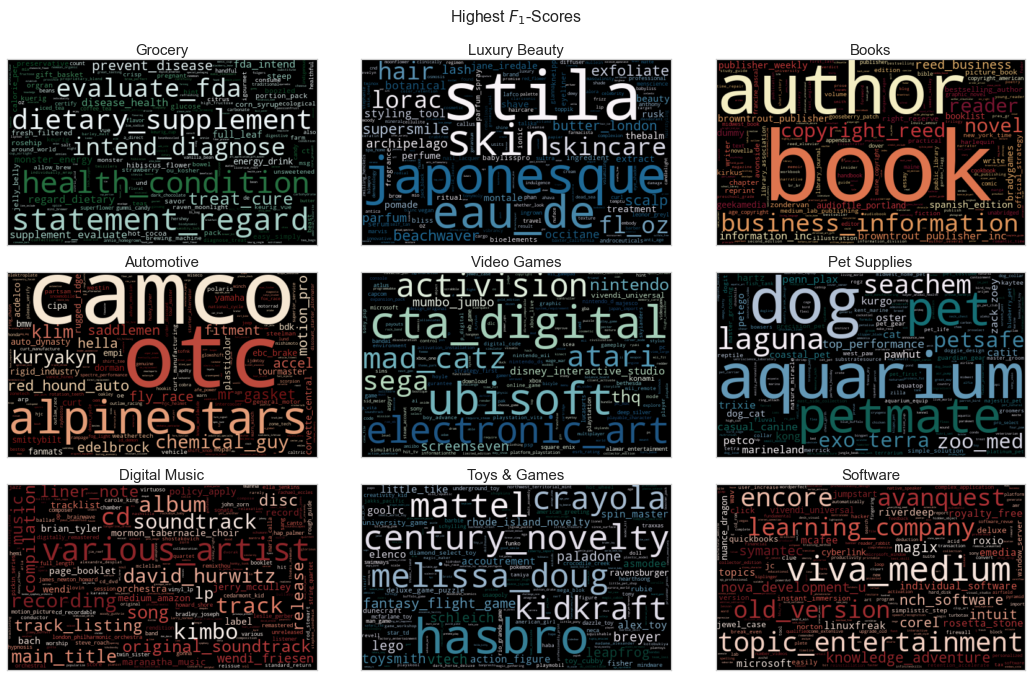

In [29]:
top_f1 = report["f1-score"].nlargest(9).index.str.title()

fig = plotting.wordcloud(coef.loc[:, top_f1], cmap=rng.choice(cmaps, 9).tolist(),)
fig.suptitle("Highest $F_{1}$-Scores", y=1.04, fontsize=16)
fig.savefig("figures/coef_top_f1.svg", bbox_inches="tight")

There are a lot of brand terms at the forefront, as I expected. However, There is also some category-specific fine print that shows up, especially in Grocery and Books. Legalistic phrases like "evaluated_fda", "fda_intended, "copyright_reed", and "rights_reserved" are among the top coefficients for these categories. This is probably because boilerplate category-related legalistic text appears repeatedly throughout the category, but does not appear in other categories.

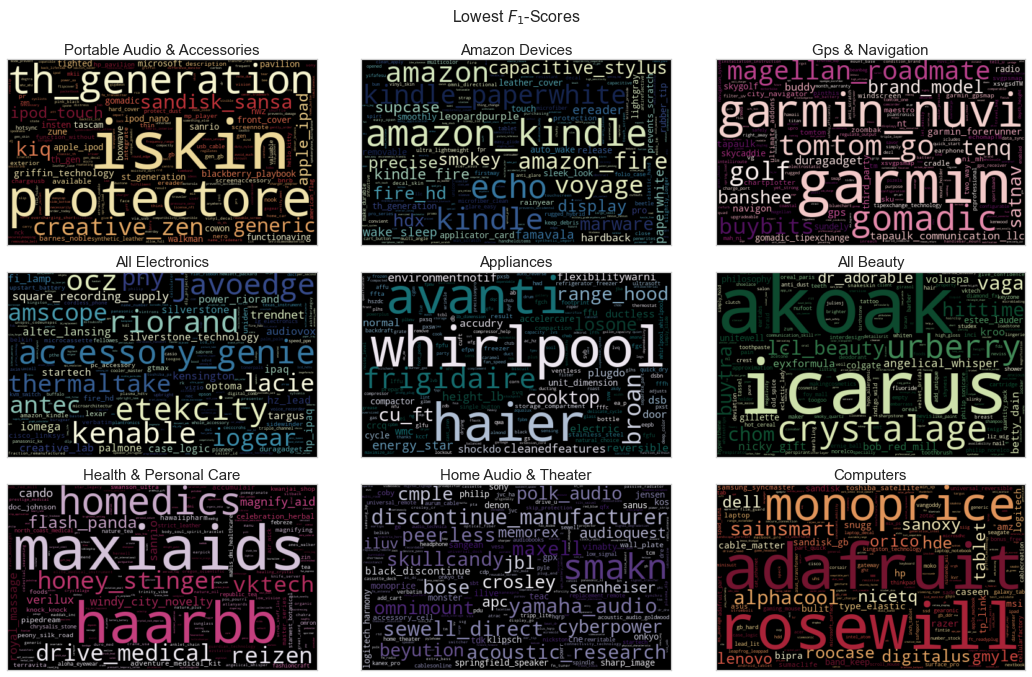

In [30]:
bottom_f1 = report["f1-score"].nsmallest(9).index.str.title()

fig = plotting.wordcloud(coef.loc[:, bottom_f1], cmap=rng.choice(cmaps, 9).tolist(),)
fig.suptitle("Lowest $F_{1}$-Scores", y=1.04, fontsize=16)
fig.savefig("figures/coef_bot_f1.svg", bbox_inches="tight")

Brand names are on top across the board for the categories with the lowest $F_{1}$-scores. The classifier still does pretty well for these categories, as evidenced by the highly recognizable brand names.

# Conclusion

I developed a highly accurate 36-class classifier for Amazon products using tried-and-true machine learning methods. One reason the model attained such a high score is that I selected a very high quality dataset. Amazon product data is both plentiful and well-labeled. The human-given category labels are highly accurate. Why? Because on Amazon, people's livelihoods are on the line (including Amazon's). It matters to sellers how they classify their products, and it matters to you too. Classification matters to businesses because it matters to customers&mdash;it can determine whether a customer buys a product or never even hears about it.

#### If you're looking to classify products with NLP, lead with the brand terms.

Brand terms ranked high in nearly every category. One could build a decent model with *only* brand terms, though I wouldn't recommend going that far. Even if you wanted an image-based classifier, brands are the first place I'd start. 

#### Don’t ignore boilerplate legalistic text, because sometimes it’s category-specific.

In fact, I recommend you gather up all the legalistic caveats and copyright statements you can get. This text is sometimes very distinctive of its category.

#### Use the model to study your competitors and scope out new suppliers.

This model can be used to analyze other business' inventories, including those of competitors. Discover new products and suppliers by directly comparing their inventories to yours under your classification scheme. See how their classification differs from yours by examining how the categories line up.

# Looking Forward

- Gather data on brands concerning their relationships and parent companies.
    - Try to expand the model's coverage to more obscure brands.
- Develop a workflow to create specialized subcategory models for each major category.
    - These will be **multilabel** classification models.
- Create a dashboard to demonstrate the accuracy and rich interpretability of the model.
- Obtain a new, unseen dataset to test the model's generalizability.